# Customer Shopping Cart Abandonment Analysis

## Introduction
Abandonment describes situations where users drop off a site before completing the expected action. The most familiar case is shopping cart abandonment, where shoppers add items to their cart but leave without buying.

**There are 13 attributes in this dataset:**

1. ID: Session ID for the customer.
2. Is_Product_Details_viewed: Whether the product detail page was viewed (0/1).
3. Session_Activity_Count: Total number of page-to-page navigations in the session.
4. No_Items_Added_InCart: Count of items added to cart.
5. No_Items_Removed_FromCart: Count of items removed from cart.
6. No_Cart_Viewed: Number of visits to the cart page.
7. No_Checkout_Confirmed: Number of successful checkouts.
8. No_Checkout_Initiated: Number of checkout attempts (successful or not).
9. No_Cart_Items_Viewed: Number of times items were viewed from the cart.
10. No_Customer_Login: Number of login events in the session.
11. No_Page_Viewed: Total pages viewed in the session.
12. Customer_Segment_Type: Segment label (0 = Target, 1 = Loyal, 2 = Untargeted).
13. Cart_Abandoned: Target. Whether the cart was abandoned (0/1).

**The dataset contains 4284 rows spread across across 13 variables.**

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle as pkl
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.special import boxcox1p
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Business Understanding
The goal is to predict whether a customer visiting the website will abandon their cart during the session. By identifying potential abandonment early, businesses can intervene with targeted offers or incentives to reduce the abandonment rate and improve overall revenue.

This analysis aims to answer key questions such as:

1.	If a customer views product details, how likely are they to abandon the cart?
2.	Which factors have the strongest influence on cart abandonment?
3.	Can we reliably predict future abandonment behavior based on session activity?

## Data Understanding

In [2]:
df = pd.read_csv('data_cart_abandonment.csv')
df.head()

,ID,Is_Product_Details_viewed,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed,Customer_Segment_Type,Cart_Abandoned
0,Session_ID_0,Yes,4,1.0,0,0.0,0,0,1,0,0,0,1
1,Session_ID_1,No,38,0.0,0,2.0,0,0,2,0,2,0,1
2,Session_ID_2,No,8,5.0,0,0.0,1,1,1,0,0,1,0
3,Session_ID_3,No,6,0.0,0,2.0,0,0,4,0,0,0,1
4,Session_ID_4,Yes,31,14.0,12,1.0,0,0,4,0,0,2,1


In [3]:
df.shape

(4284, 13)

In [4]:
df.dtypes

ID                            object
Is_Product_Details_viewed     object
Session_Activity_Count         int64
No_Items_Added_InCart        float64
No_Items_Removed_FromCart      int64
No_Cart_Viewed               float64
No_Checkout_Confirmed          int64
No_Checkout_Initiated          int64
No_Cart_Items_Viewed           int64
No_Customer_Login              int64
No_Page_Viewed                 int64
Customer_Segment_Type          int64
Cart_Abandoned                 int64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         4284 non-null   object 
 1   Is_Product_Details_viewed  4284 non-null   object 
 2   Session_Activity_Count     4284 non-null   int64  
 3   No_Items_Added_InCart      4275 non-null   float64
 4   No_Items_Removed_FromCart  4284 non-null   int64  
 5   No_Cart_Viewed             4275 non-null   float64
 6   No_Checkout_Confirmed      4284 non-null   int64  
 7   No_Checkout_Initiated      4284 non-null   int64  
 8   No_Cart_Items_Viewed       4284 non-null   int64  
 9   No_Customer_Login          4284 non-null   int64  
 10  No_Page_Viewed             4284 non-null   int64  
 11  Customer_Segment_Type      4284 non-null   int64  
 12  Cart_Abandoned             4284 non-null   int64  
dtypes: float64(2), int64(9), object(2)
memory usage:

In [6]:
df.describe()

,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed,Customer_Segment_Type,Cart_Abandoned
count,4284.000000,4275.000000,4284.000000,4275.000000,4284.000000,4284.000000,4284.000000,4284.000000,4284.000000,4284.000000,4284.000000
mean,13.878151,3.488421,0.867180,1.444211,0.187208,0.980159,2.295985,0.169234,2.348506,0.563259,0.856209
std,15.934084,6.789401,3.070022,2.082496,0.517691,1.140525,6.052666,0.400299,2.868862,0.703856,0.350918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,10.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,1.000000
75%,17.000000,5.000000,0.000000,2.000000,0.000000,1.000000,2.000000,0.000000,3.000000,1.000000,1.000000
max,436.000000,225.000000,50.000000,34.000000,11.000000,14.000000,256.000000,3.000000,35.000000,2.000000,1.000000


In [9]:
df.Cart_Abandoned = pd.Categorical(df.Cart_Abandoned)
df.Cart_Abandoned.dtypes

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [10]:
df.Customer_Segment_Type = pd.Categorical(df.Customer_Segment_Type)

In [11]:
df.dtypes

ID                             object
Is_Product_Details_viewed      object
Session_Activity_Count          int64
No_Items_Added_InCart         float64
No_Items_Removed_FromCart       int64
No_Cart_Viewed                float64
No_Checkout_Confirmed           int64
No_Checkout_Initiated           int64
No_Cart_Items_Viewed            int64
No_Customer_Login               int64
No_Page_Viewed                  int64
Customer_Segment_Type        category
Cart_Abandoned               category
dtype: object

<Axes: xlabel='count', ylabel='Cart_Abandoned'>

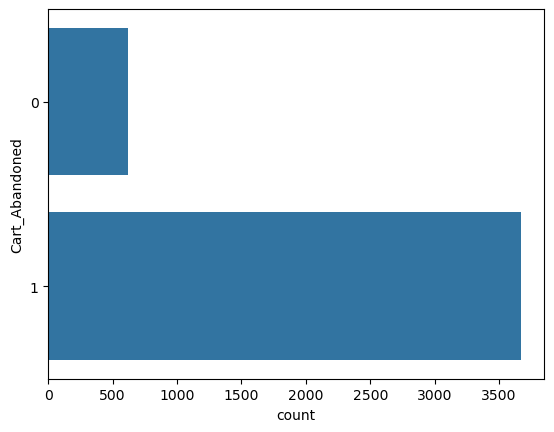

In [12]:
sns.countplot(df.Cart_Abandoned)

### Exploratory Data Analysis

#### i) Univariate Analysis

In [13]:
num_cols = df.select_dtypes(include=["float64","int64"])
cat_cols = df.select_dtypes(include=["object","category"]).drop(["ID"],axis=1)

In [14]:
num_cols.shape

(4284, 9)

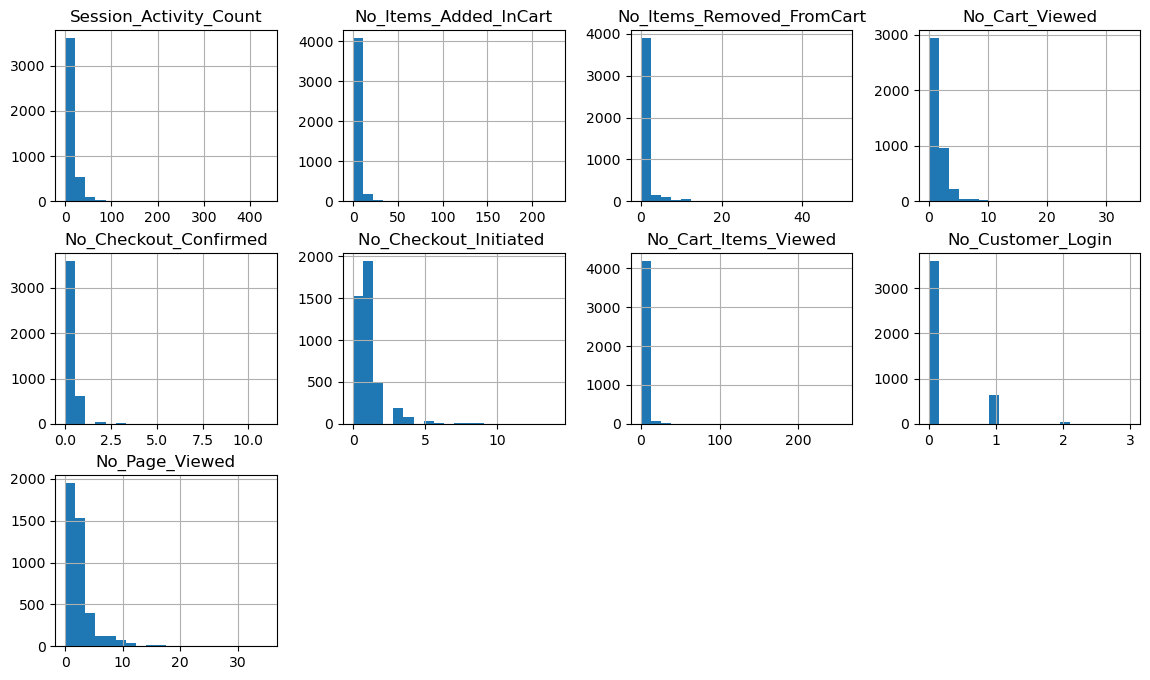

In [16]:
num_cols.hist(bins=20, figsize=(14, 8), layout=(3, 4));

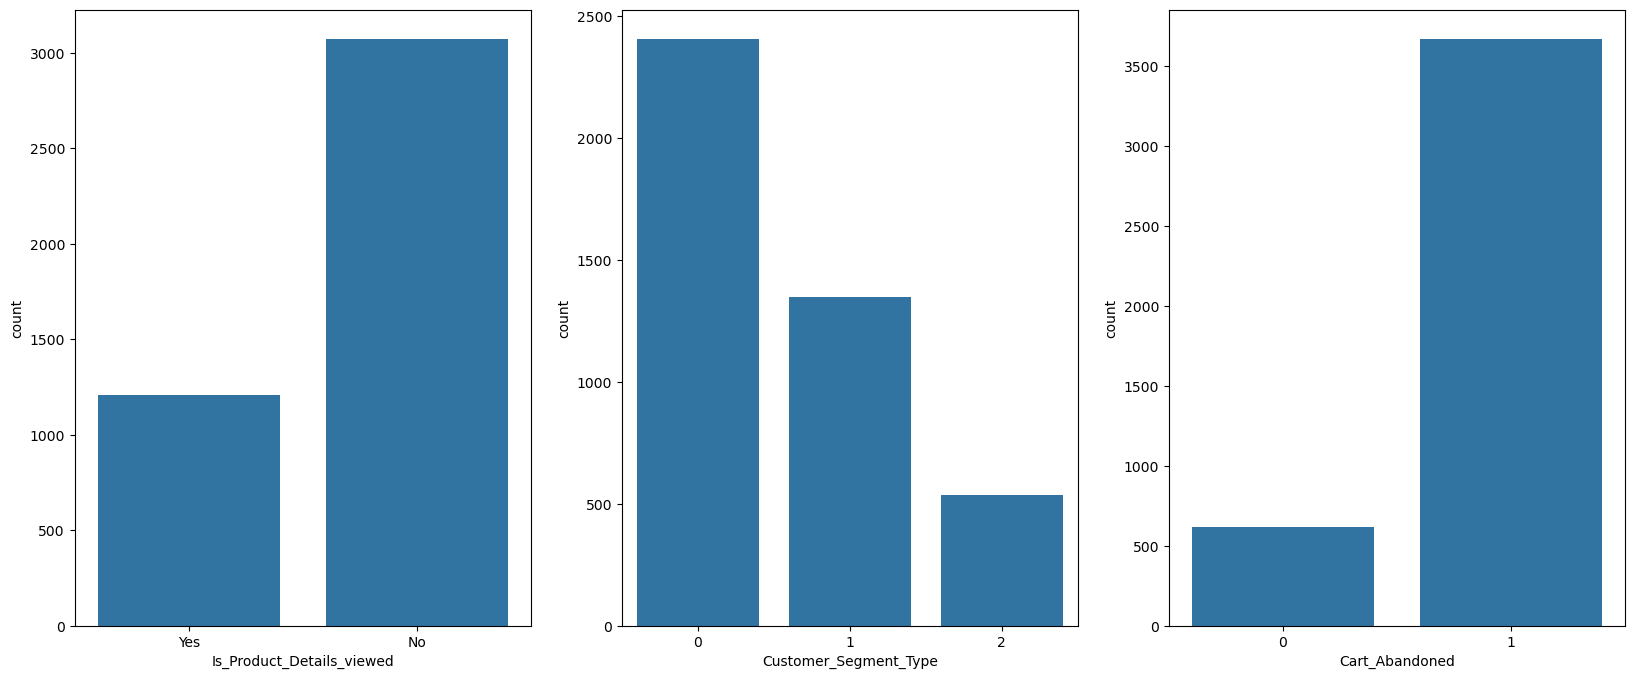

In [19]:
f, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 8))
for i,j in zip(cat_cols.columns.tolist(), ax.flatten()):
    sns.countplot(x=cat_cols[i],ax=j)

#### ii) Bivariate Analysis

#### 1. Categorical Feature: Is_Product_Details_viewed vs. Cart_Abandoned

Part 1: Impact of Viewing Product Details on Cart Abandonment

Question: When a customer views product details, how likely are they to abandon the cart?

<Axes: xlabel='Is_Product_Details_viewed', ylabel='count'>

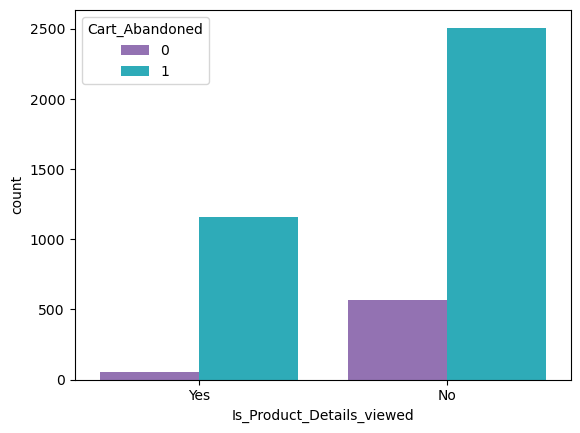

In [21]:
sns.countplot(x=df.Is_Product_Details_viewed,hue=df.Cart_Abandoned, palette=["#9467bd", "#17becf"])

#### 2.1 Numerical Features vs. Cart Abandonment (Boxplot)

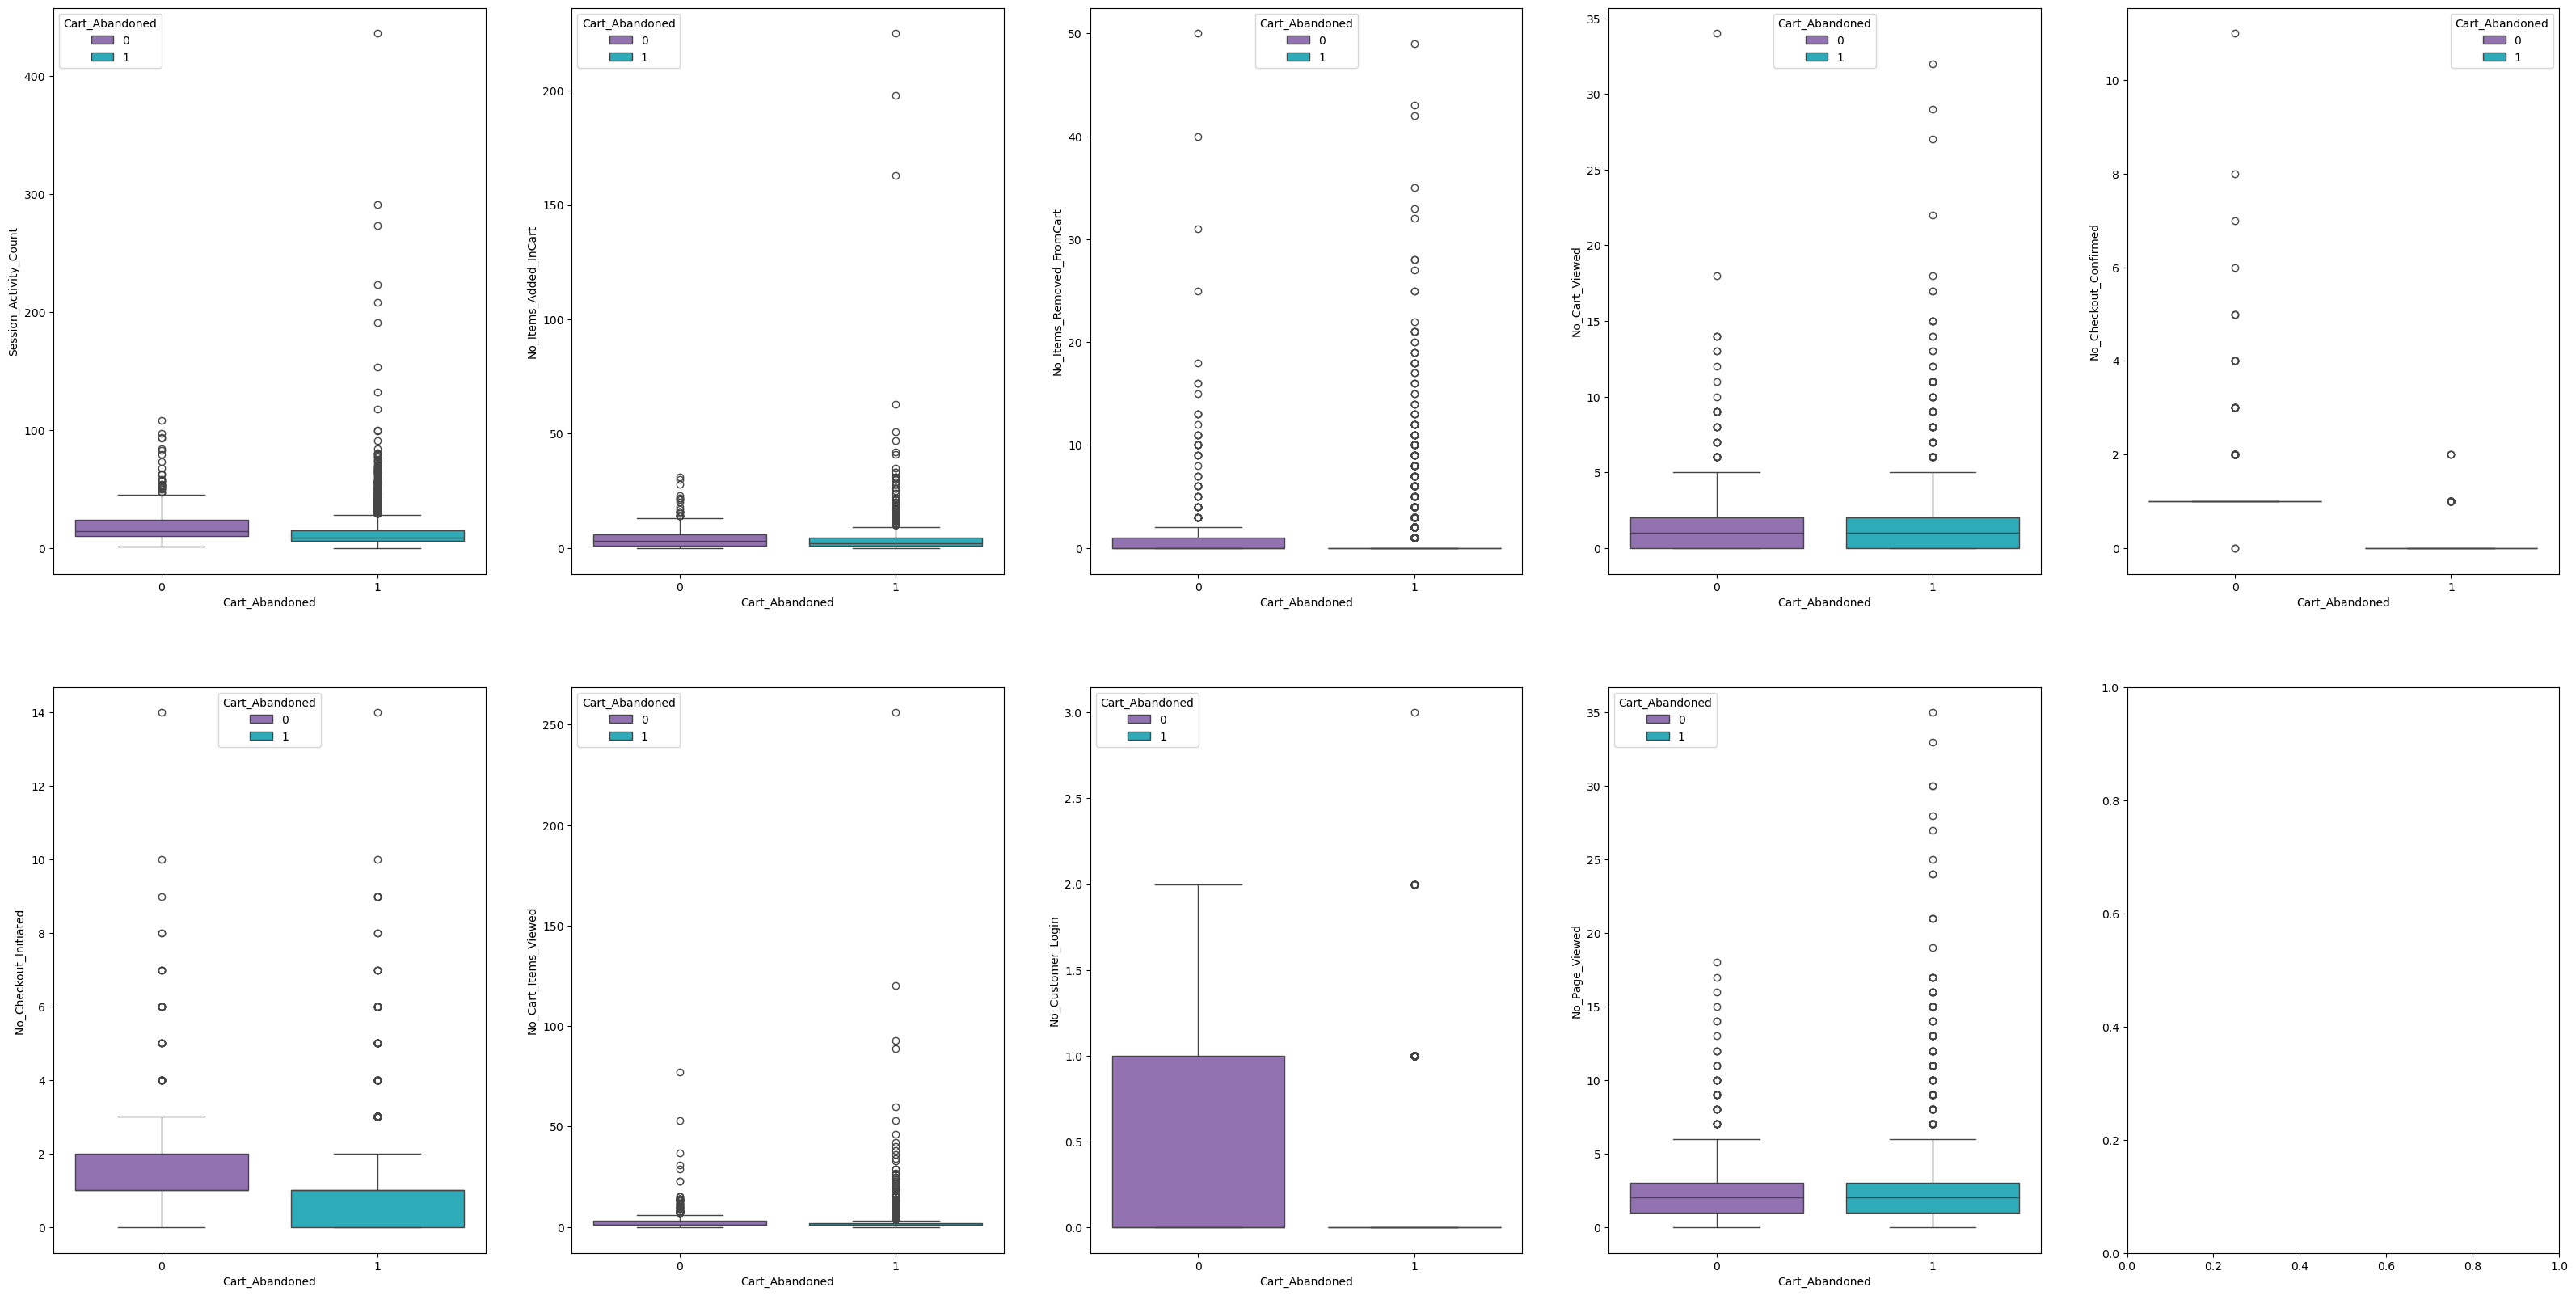

In [32]:
fig, ax = plt.subplots(2, 5, figsize=(40, 20))
for var, subplot in zip(num_cols.columns.tolist(), ax.flatten()):
    sns.boxplot(x=cat_cols["Cart_Abandoned"], y=num_cols[var], ax=subplot, hue=df.Cart_Abandoned, palette=["#9467bd", "#17becf"])

#### 2.2 Correlation Plot of Independent Attributes

<Axes: >

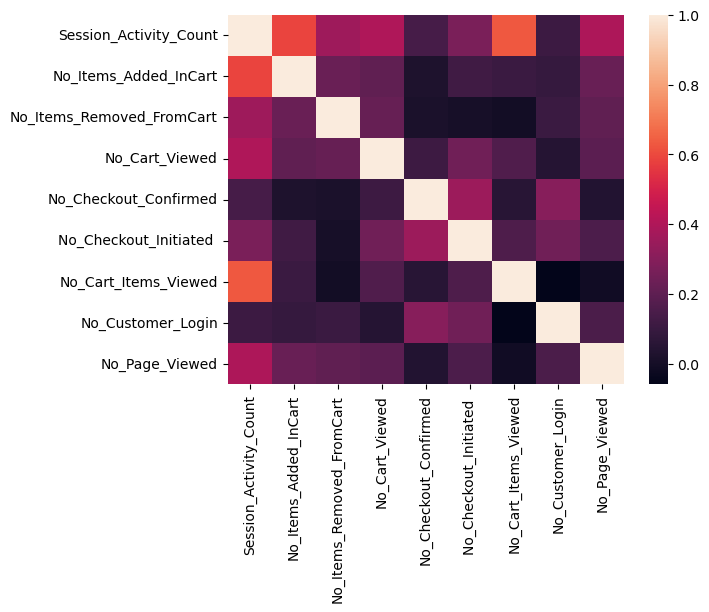

In [33]:
corr = num_cols.corr()
sns.heatmap(corr)

## 3. Data Preparation

### Imputing Missing Values

In [34]:
df_copy = df.copy()

In [35]:
df_copy.isna().sum()

ID                           0
Is_Product_Details_viewed    0
Session_Activity_Count       0
No_Items_Added_InCart        9
No_Items_Removed_FromCart    0
No_Cart_Viewed               9
No_Checkout_Confirmed        0
No_Checkout_Initiated        0
No_Cart_Items_Viewed         0
No_Customer_Login            0
No_Page_Viewed               0
Customer_Segment_Type        0
Cart_Abandoned               0
dtype: int64

In [36]:
null_cols = df_copy.columns[df_copy.isna().any()].tolist()
null_cols

['No_Items_Added_InCart', 'No_Cart_Viewed']

In [37]:
df_copy[null_cols].head()

,No_Items_Added_InCart,No_Cart_Viewed
0,1.0,0.0
1,0.0,2.0
2,5.0,0.0
3,0.0,2.0
4,14.0,1.0


In [38]:
df_copy.isna().sum()

ID                           0
Is_Product_Details_viewed    0
Session_Activity_Count       0
No_Items_Added_InCart        9
No_Items_Removed_FromCart    0
No_Cart_Viewed               9
No_Checkout_Confirmed        0
No_Checkout_Initiated        0
No_Cart_Items_Viewed         0
No_Customer_Login            0
No_Page_Viewed               0
Customer_Segment_Type        0
Cart_Abandoned               0
dtype: int64

In [40]:
df_copy['No_Items_Added_InCart'] = df_copy['No_Items_Added_InCart'].fillna(df_copy['No_Items_Added_InCart'].mean()) 

In [39]:
df_copy.dtypes

ID                             object
Is_Product_Details_viewed      object
Session_Activity_Count          int64
No_Items_Added_InCart         float64
No_Items_Removed_FromCart       int64
No_Cart_Viewed                float64
No_Checkout_Confirmed           int64
No_Checkout_Initiated           int64
No_Cart_Items_Viewed            int64
No_Customer_Login               int64
No_Page_Viewed                  int64
Customer_Segment_Type        category
Cart_Abandoned               category
dtype: object

In [41]:
df_copy['No_Cart_Viewed'] = df_copy['No_Cart_Viewed'].fillna(df_copy['No_Cart_Viewed'].mean()) 

In [44]:
df_copy[null_cols] = df_copy[null_cols].astype("int64")

In [45]:
df_copy.isna().sum()

ID                           0
Is_Product_Details_viewed    0
Session_Activity_Count       0
No_Items_Added_InCart        0
No_Items_Removed_FromCart    0
No_Cart_Viewed               0
No_Checkout_Confirmed        0
No_Checkout_Initiated        0
No_Cart_Items_Viewed         0
No_Customer_Login            0
No_Page_Viewed               0
Customer_Segment_Type        0
Cart_Abandoned               0
dtype: int64

### Handling Outliers with Min-Max Normalization

In [46]:
num_cols = df_copy.select_dtypes(include=["int64"])
cat_cols = df_copy.select_dtypes(include=["object","category"]).drop(["ID"],axis=1)

In [47]:
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(num_cols)
x_scaled

array([[0.00917431, 0.00444444, 0.        , ..., 0.00390625, 0.        ,
        0.        ],
       [0.08715596, 0.        , 0.        , ..., 0.0078125 , 0.        ,
        0.05714286],
       [0.01834862, 0.02222222, 0.        , ..., 0.00390625, 0.        ,
        0.        ],
       ...,
       [0.00917431, 0.00444444, 0.        , ..., 0.00390625, 0.        ,
        0.        ],
       [0.01834862, 0.01333333, 0.        , ..., 0.00390625, 0.        ,
        0.05714286],
       [0.07110092, 0.01777778, 0.        , ..., 0.02734375, 0.        ,
        0.02857143]])

In [53]:
normalized_df = pd.DataFrame(x_scaled,columns=num_cols.columns)
normalized_df.head(5)

,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed
0,0.009174,0.004444,0.00,0.000000,0.000000,0.000000,0.003906,0.0,0.000000
1,0.087156,0.000000,0.00,0.058824,0.000000,0.000000,0.007812,0.0,0.057143
2,0.018349,0.022222,0.00,0.000000,0.090909,0.071429,0.003906,0.0,0.000000
3,0.013761,0.000000,0.00,0.058824,0.000000,0.000000,0.015625,0.0,0.000000
4,0.071101,0.062222,0.24,0.029412,0.000000,0.000000,0.015625,0.0,0.000000


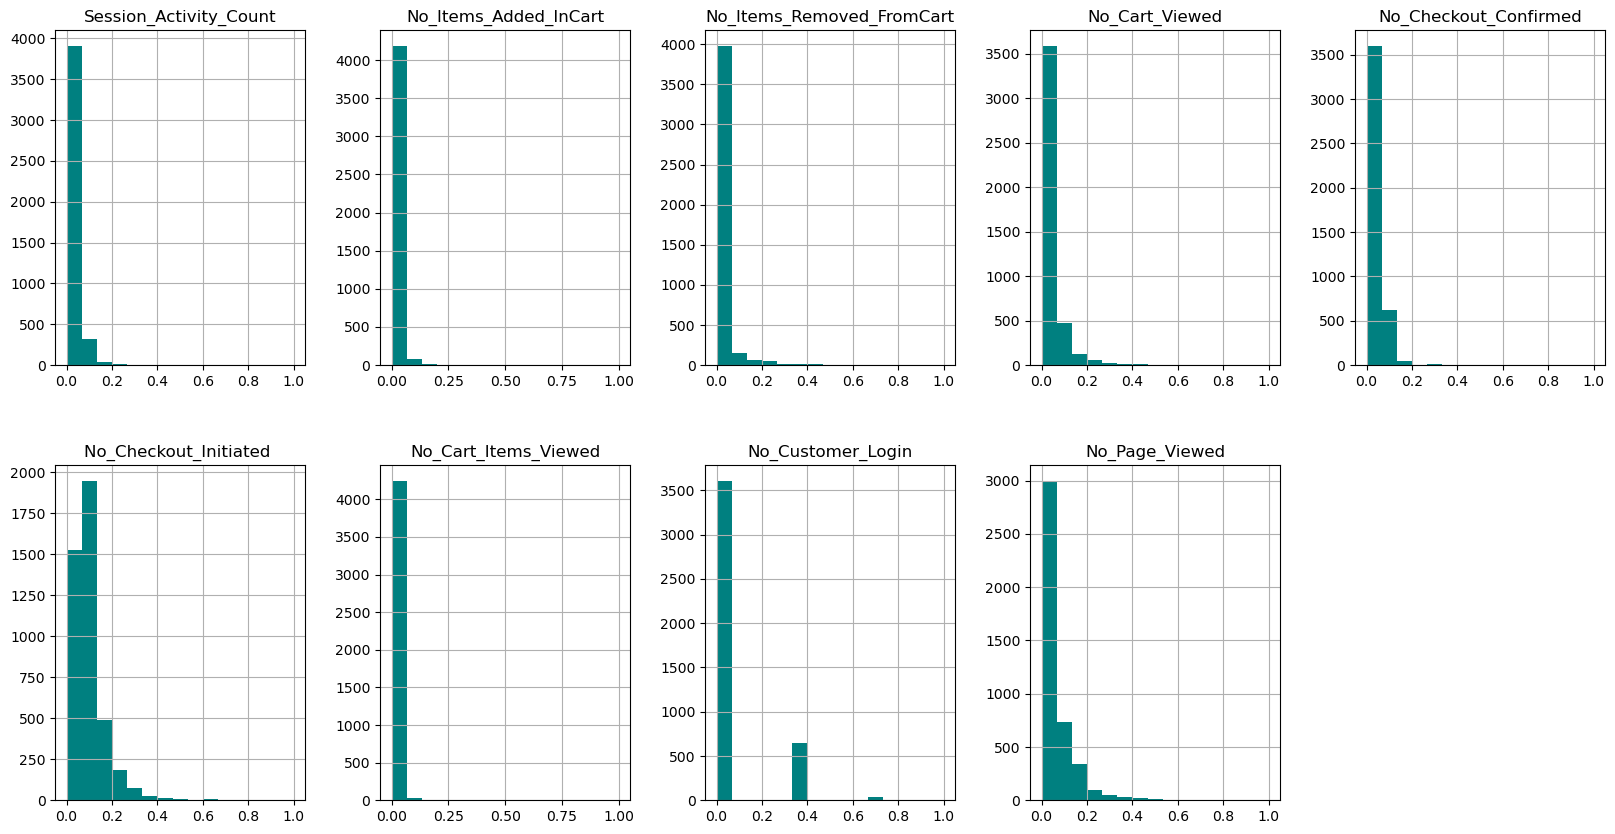

In [66]:
normalized_df.hist(bins=15, figsize=(20, 10), layout=(2, 5), color="teal");

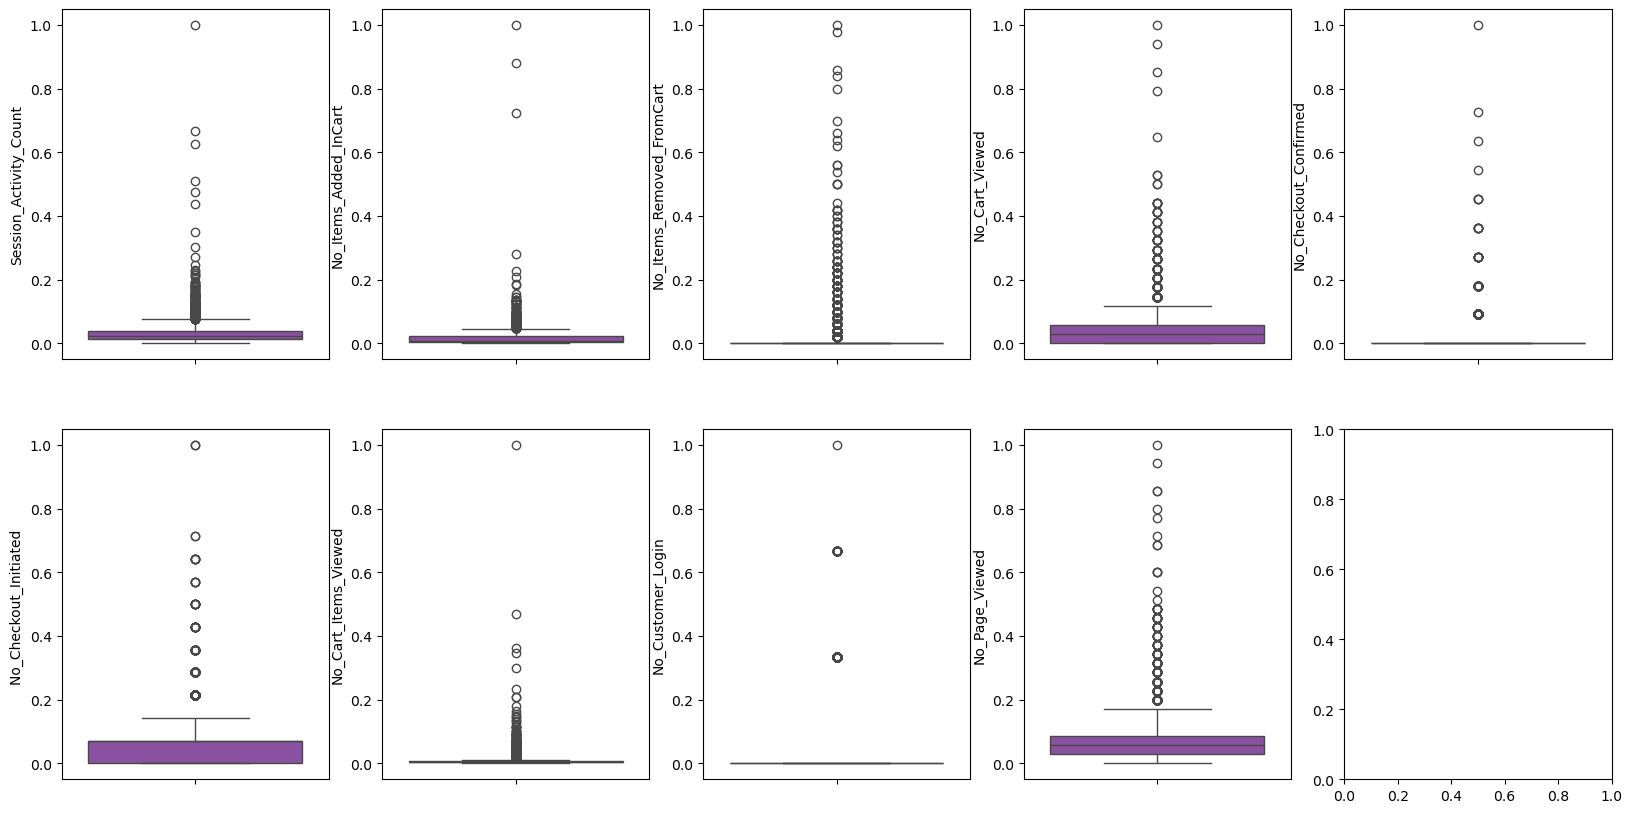

In [65]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for var, subplot in zip(normalized_df.columns.tolist(), ax.flatten()):
    sns.boxplot(y=normalized_df[var], ax=subplot, color = '#8e44ad')

### Handling Outliers with Box-Cox Transformation

In [61]:

normalized_df_boxcox = boxcox1p(num_cols, 0)


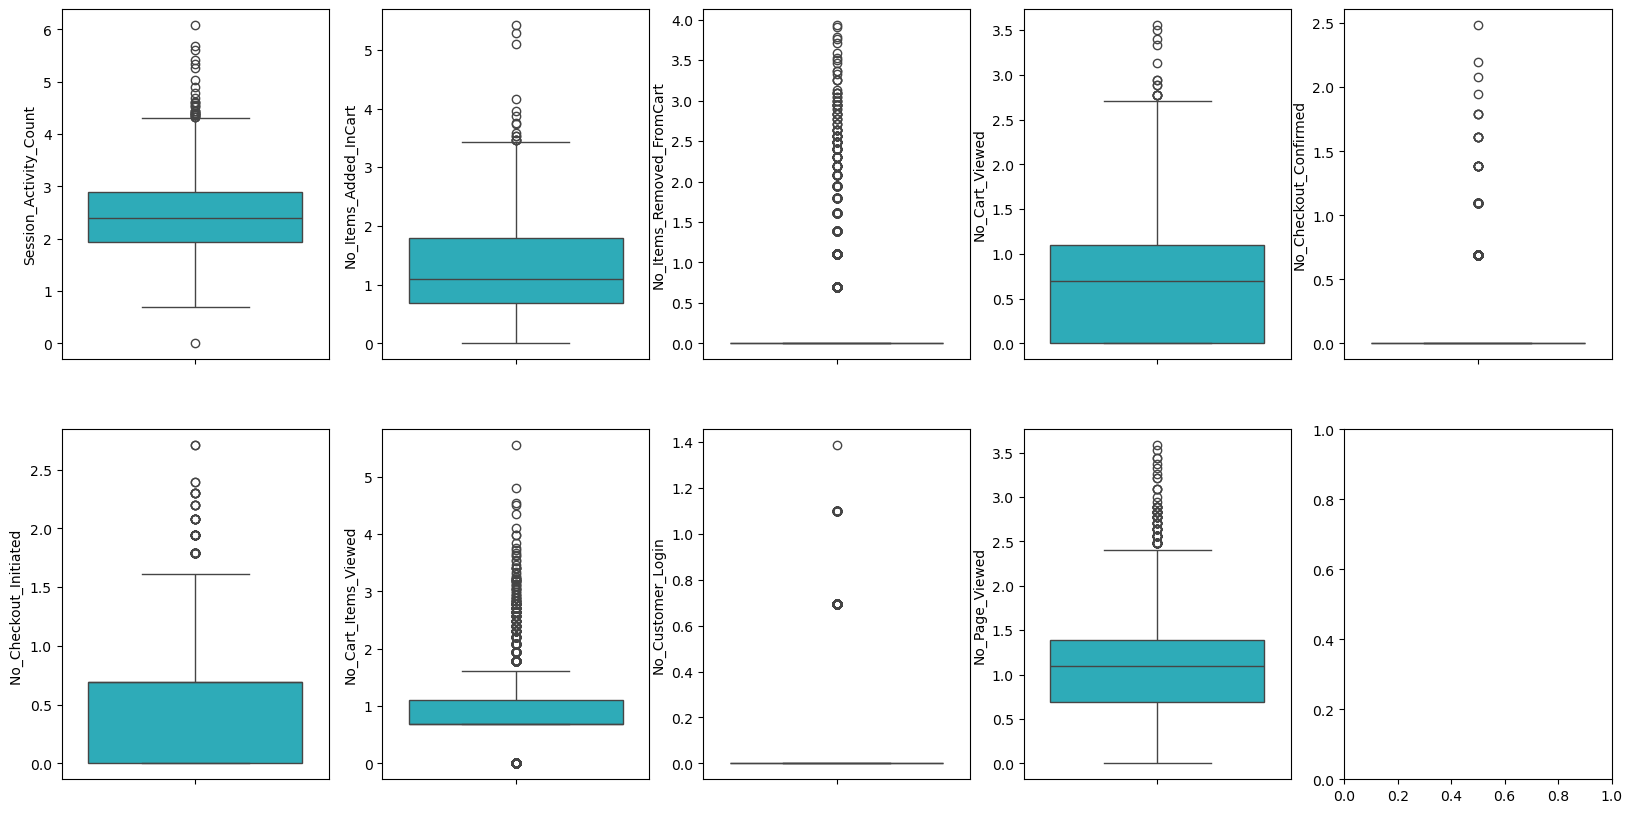

In [64]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for var, subplot in zip(normalized_df_boxcox.columns.tolist(), ax.flatten()):
    sns.boxplot(y=normalized_df_boxcox[var], ax=subplot, color="#17becf")

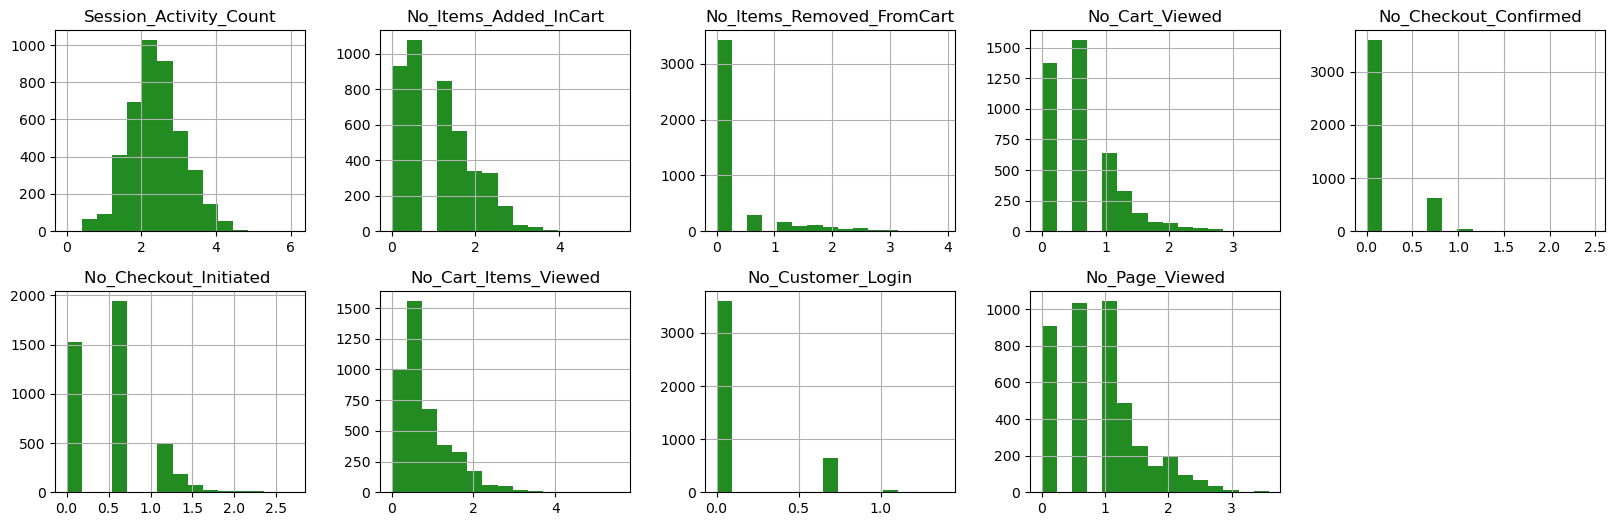

In [68]:
normalized_df_boxcox.hist(bins=15, figsize=(20, 6), layout=(2, 5), color = 'forestgreen');

In [69]:
normalized_df_boxcox.head(5)

,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed
0,1.609438,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.0,0.000000
1,3.663562,0.000000,0.000000,1.098612,0.000000,0.000000,1.098612,0.0,1.098612
2,2.197225,1.791759,0.000000,0.000000,0.693147,0.693147,0.693147,0.0,0.000000
3,1.945910,0.000000,0.000000,1.098612,0.000000,0.000000,1.609438,0.0,0.000000
4,3.465736,2.708050,2.564949,0.693147,0.000000,0.000000,1.609438,0.0,0.000000


In [72]:
normalized_df_boxcox["ID"]= df_copy.ID
normalized_df_boxcox.set_index('ID',inplace=True)


In [73]:
normalized_df_boxcox.reset_index(inplace=True)

In [76]:
df_final= normalized_df_boxcox.join(cat_cols)
df_final.head(5)

,ID,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed,Is_Product_Details_viewed,Customer_Segment_Type,Cart_Abandoned
0,Session_ID_0,1.609438,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.0,0.000000,Yes,0,1
1,Session_ID_1,3.663562,0.000000,0.000000,1.098612,0.000000,0.000000,1.098612,0.0,1.098612,No,0,1
2,Session_ID_2,2.197225,1.791759,0.000000,0.000000,0.693147,0.693147,0.693147,0.0,0.000000,No,1,0
3,Session_ID_3,1.945910,0.000000,0.000000,1.098612,0.000000,0.000000,1.609438,0.0,0.000000,No,0,1
4,Session_ID_4,3.465736,2.708050,2.564949,0.693147,0.000000,0.000000,1.609438,0.0,0.000000,Yes,2,1


In [78]:
df_final["Is_Product_Details_viewed"] = df_final["Is_Product_Details_viewed"].replace({"Yes": 1, "No": 0})

In [79]:
df_final.dtypes

ID                             object
Session_Activity_Count        float64
No_Items_Added_InCart         float64
No_Items_Removed_FromCart     float64
No_Cart_Viewed                float64
No_Checkout_Confirmed         float64
No_Checkout_Initiated         float64
No_Cart_Items_Viewed          float64
No_Customer_Login             float64
No_Page_Viewed                float64
Is_Product_Details_viewed       int64
Customer_Segment_Type        category
Cart_Abandoned               category
dtype: object

In [80]:
df_final.Is_Product_Details_viewed = pd.Categorical(df_final.Is_Product_Details_viewed)

### Feature Selection

### Feature Selection using RFE

In [81]:
X = df_final.iloc[:,1:12]
X.shape

(4284, 11)

In [82]:
y = df_final["Cart_Abandoned"]
y.name

'Cart_Abandoned'

In [83]:
lr = LogisticRegression()
lr.fit(X,y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=7, verbose = 3 )
fit=rfe.fit(X,y)
print("Num Features: %d"% fit.n_features_) 
print("Selected Features: %s"% fit.support_) 
print("Feature Ranking: %s"% fit.ranking_)

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Num Features: 7
Selected Features: [ True False False  True  True  True False  True  True  True False]
Feature Ranking: [1 2 4 1 1 1 5 1 1 1 3]


In [84]:
l = [i for i,x in enumerate(list(fit.support_)) if x == True]

In [85]:
X.columns

Index(['Session_Activity_Count', 'No_Items_Added_InCart',
       'No_Items_Removed_FromCart', 'No_Cart_Viewed', 'No_Checkout_Confirmed',
       'No_Checkout_Initiated ', 'No_Cart_Items_Viewed', 'No_Customer_Login',
       'No_Page_Viewed', 'Is_Product_Details_viewed', 'Customer_Segment_Type'],
      dtype='object')

In [86]:
final_features = [X[X.columns[l[i]]].name for i,x in enumerate(l)]

In [87]:
final_features

['Session_Activity_Count',
 'No_Cart_Viewed',
 'No_Checkout_Confirmed',
 'No_Checkout_Initiated ',
 'No_Customer_Login',
 'No_Page_Viewed',
 'Is_Product_Details_viewed']

### Feature Selection using Random Forest Classifier

In [88]:
# Create a random forest classifier
rf_clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
rf_clf.fit(X, y)
feature_weightage_dict = dict()
# Print the name and gini importance of each feature
for feature in zip(X.columns, rf_clf.feature_importances_):
    feature_weightage_dict.update({feature[0]:feature[1]})

In [89]:
feature_weightage_dict

{'Session_Activity_Count': 0.05052820130173562,
 'No_Items_Added_InCart': 0.02554555656055808,
 'No_Items_Removed_FromCart': 0.010166703364489804,
 'No_Cart_Viewed': 0.01781683382979301,
 'No_Checkout_Confirmed': 0.7342195775011403,
 'No_Checkout_Initiated ': 0.04416354805735399,
 'No_Cart_Items_Viewed': 0.01870039236943886,
 'No_Customer_Login': 0.056027414133408074,
 'No_Page_Viewed': 0.02712266683169765,
 'Is_Product_Details_viewed': 0.009765554865757418,
 'Customer_Segment_Type': 0.005943551184627195}

In [90]:
feature_importance_sorted = sorted(feature_weightage_dict.items(), key=lambda kv: kv[1], reverse = True)

In [91]:
feature_importance_sorted

[('No_Checkout_Confirmed', 0.7342195775011403),
 ('No_Customer_Login', 0.056027414133408074),
 ('Session_Activity_Count', 0.05052820130173562),
 ('No_Checkout_Initiated ', 0.04416354805735399),
 ('No_Page_Viewed', 0.02712266683169765),
 ('No_Items_Added_InCart', 0.02554555656055808),
 ('No_Cart_Items_Viewed', 0.01870039236943886),
 ('No_Cart_Viewed', 0.01781683382979301),
 ('No_Items_Removed_FromCart', 0.010166703364489804),
 ('Is_Product_Details_viewed', 0.009765554865757418),
 ('Customer_Segment_Type', 0.005943551184627195)]

In [92]:
df_final.columns

Index(['ID', 'Session_Activity_Count', 'No_Items_Added_InCart',
       'No_Items_Removed_FromCart', 'No_Cart_Viewed', 'No_Checkout_Confirmed',
       'No_Checkout_Initiated ', 'No_Cart_Items_Viewed', 'No_Customer_Login',
       'No_Page_Viewed', 'Is_Product_Details_viewed', 'Customer_Segment_Type',
       'Cart_Abandoned'],
      dtype='object')

### Part 2: What are the important factors related to cart abandonment?

After comparing both methods of feature selection, we find that the following attributes carry the highest importance in predicting cart abandonment:
1. No_Items_Added_InCart
2. No_Checkout_Confirmed
3. No_Checkout_Initiated
4. No_Customer_Login
5. No_Page_Viewed

These features will be retained for model training, as they provide the strongest signals about whether a customer is likely to abandon their cart.

### Train-Validation Split

In [93]:
X = df_final.iloc[:,[5,6,8,9,2]]
y = df_final.loc[:,["Cart_Abandoned"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)


### Over-Sampling with SMOTE

In [96]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=2, k_neighbors=5)
X_train, y_train = smote.fit_resample(X_train, y_train)

#### Train–Validation Split after SMOTE

In [97]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train, y_train, test_size=0.40, random_state=0)

### 4. Model Builiding And Prediction

#### Part 3: How can we predict if a customer will abandon the cart in the future?

The goal here is to use the selected features to train machine learning models that can predict whether a customer is likely to abandon their cart during a session. By applying these models to new sessions, businesses can proactively identify at-risk customers and take actions (such as offering discounts or reminders) to reduce abandonment.

In [99]:
lr1 = LogisticRegression()

# flatten y before training
lr1.fit(X_train_new, y_train_new.values.ravel())

# predictions
y_pred_new = lr1.predict(X_test_new)
y_pred = lr1.predict(X_test)

## 5. Model Evaluation

In [100]:
print(" accuracy is %2.3f" % accuracy_score(y_test_new, y_pred_new))
print(" Kappa is %f" %cohen_kappa_score(y_test_new, y_pred_new))

 accuracy is 0.988
 Kappa is 0.976122


In [101]:
print(" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(" Kappa is %f" %cohen_kappa_score(y_test, y_pred))

 accuracy is 0.984
 Kappa is 0.936154


### Saving the Model with Pickle

In [102]:
lr1.predict(X_test)

array([1, 1, 1, ..., 0, 1, 1])

In [103]:
model_out = open("train_classifier","wb")
pkl.dump(lr1,model_out)

## 6. Conclusion

This workflow predicts which sessions are likely to end in cart abandonment. With those risk scores, we can trigger timely nudges like small discounts, free shipping thresholds, or reminder emails to help customers finish checkout. What this really means is we move from reacting after a lost sale to intervening before it happens.